In [1]:
import numpy as np
import os
import onnxruntime as ort
import tqdm
import cv2
import matplotlib.pyplot as plt

model_path = '../model.onnx'

#Load some example images
im1 = cv2.imread('../assets/ref.png', cv2.IMREAD_COLOR)
im2 = cv2.imread('../assets/tgt.png', cv2.IMREAD_COLOR)

## Simple function that fits an homography in a set of matches and draw the homography transform

In [2]:
def warp_corners_and_draw_matches(ref_points, dst_points, img1, img2):
    # Calculate the Homography matrix
    H, mask = cv2.findHomography(ref_points, dst_points, cv2.USAC_MAGSAC, 3.5, maxIters=1_000, confidence=0.999)
    mask = mask.flatten()

    # Get corners of the first image (image1)
    h, w = img1.shape[:2]
    corners_img1 = np.array([[0, 0], [w-1, 0], [w-1, h-1], [0, h-1]], dtype=np.float32).reshape(-1, 1, 2)

    # Warp corners to the second image (image2) space
    warped_corners = cv2.perspectiveTransform(corners_img1, H)

    # Draw the warped corners in image2
    img2_with_corners = img2.copy()
    for i in range(len(warped_corners)):
        start_point = tuple(warped_corners[i-1][0].astype(int))
        end_point = tuple(warped_corners[i][0].astype(int))
        cv2.line(img2_with_corners, start_point, end_point, (0, 255, 0), 4)  # Using solid green for corners

    # Prepare keypoints and matches for drawMatches function
    keypoints1 = [cv2.KeyPoint(p[0], p[1], 5) for p in ref_points]
    keypoints2 = [cv2.KeyPoint(p[0], p[1], 5) for p in dst_points]
    matches = [cv2.DMatch(i,i,0) for i in range(len(mask)) if mask[i]]

    # Draw inlier matches
    img_matches = cv2.drawMatches(img1, keypoints1, img2_with_corners, keypoints2, matches, None,
                                  matchColor=(0, 255, 0), flags=2)

    return img_matches

In [3]:
providers = [
    ('TensorrtExecutionProvider', {
        'device_id': 0,
        'trt_fp16_enable': True,
        'trt_engine_cache_enable': True,
        'trt_engine_cache_path': './trt_engine_cache',
        'trt_engine_cache_prefix': 'model',
    }),
    ('CUDAExecutionProvider', {
        'device_id': 0,
        'gpu_mem_limit': 2 * 1024 * 1024 * 1024,
    }),
    ('CPUExecutionProvider',{ 
    })
]
ort_session = ort.InferenceSession(model_path, providers=providers)

# print the input,output names and shapes
for i in range(len(ort_session.get_inputs())):
    print(f"Input name: {ort_session.get_inputs()[i].name}, shape: {ort_session.get_inputs()[i].shape}")
for i in range(len(ort_session.get_outputs())):
    print(f"Output name: {ort_session.get_outputs()[i].name}, shape: {ort_session.get_outputs()[i].shape}")

Input name: image0, shape: [1, 3, 'height', 'width']
Input name: image1, shape: [1, 3, 'height', 'width']
Output name: mkpts_0, shape: ['Slicemkpts_0_dim_0', 2]
Output name: mkpts_1, shape: ['Slicemkpts_0_dim_0', 2]


2024-05-04 15:29:08.029531075 [W:onnxruntime:Default, tensorrt_execution_provider.h:83 log] [2024-05-04 07:29:08 WARNING] onnx2trt_utils.cpp:374: Your ONNX model has been generated with INT64 weights, while TensorRT does not natively support INT64. Attempting to cast down to INT32.
2024-05-04 15:29:08.029587024 [W:onnxruntime:Default, tensorrt_execution_provider.h:83 log] [2024-05-04 07:29:08 WARNING] onnx2trt_utils.cpp:400: One or more weights outside the range of INT32 was clamped
2024-05-04 15:29:08.049918423 [W:onnxruntime:Default, tensorrt_execution_provider.h:83 log] [2024-05-04 07:29:08 WARNING] Tensor DataType is determined at build time for tensors not marked as input or output.
2024-05-04 15:29:08.049959418 [W:onnxruntime:Default, tensorrt_execution_provider.h:83 log] [2024-05-04 07:29:08 WARNING] Tensor DataType is determined at build time for tensors not marked as input or output.
2024-05-04 15:29:08.061646875 [W:onnxruntime:Default, tensorrt_execution_provider.h:83 log] [2

## Prepare the input tensor

In [4]:
#im1 = cv2.resize(im1, (640, 640))
#im2 = cv2.resize(im2, (640, 640))

input_array_1 = im1.transpose(2, 0, 1).astype(np.float32) / 255.0
input_array_1 = np.expand_dims(input_array_1, axis=0)
input_array_2 = im2.transpose(2, 0, 1).astype(np.float32) / 255.0
input_array_2 = np.expand_dims(input_array_2, axis=0)

inputs = {
    ort_session.get_inputs()[0].name: input_array_1,
    ort_session.get_inputs()[1].name: input_array_2
}

## Run matching

In [5]:
outputs = ort_session.run(None, inputs)

In [6]:
import time

# Run the model 100 times to get an average time
times = []
for i in tqdm.tqdm(range(100)):
    start = time.time()
    outputs = ort_session.run(None, inputs)
    times.append(time.time() - start)

print(f"Average time: {np.mean(times):.4f} seconds")

100%|██████████| 100/100 [00:00<00:00, 108.79it/s]

Average time: 0.0092 seconds


## Draw the matches

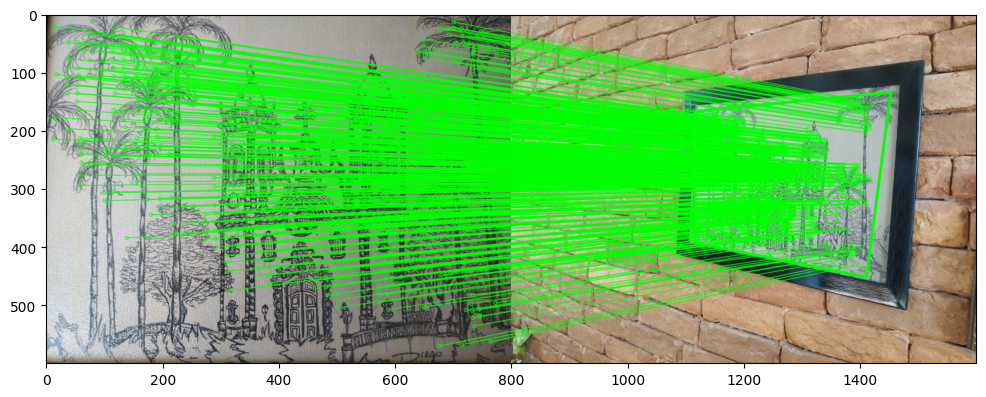

In [7]:
mkpts_0, mkpts_1 = outputs

canvas = warp_corners_and_draw_matches(mkpts_0, mkpts_1, im1, im2)
plt.figure(figsize=(12,12))
plt.imshow(canvas[..., ::-1])
plt.show()